In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn import preprocessing
import xgboost as xgb
pd.set_option('display.max_columns', None)

In [2]:
df_tr = pd.read_csv('titanic/train.csv')
df_te = pd.read_csv('titanic/test.csv')
display(df_tr.head(), df_te.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
print('Train null values')
print(df_tr.isnull().sum())
print('-----------------------------')
print('Test null values')
print(df_te.isnull().sum())
# do not consider Cabin because of too many missing value

Train null values
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------------------------
Test null values
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
# combine the train and test set to see the data distribution
df = df_tr.append(df_te).reset_index(drop=True)
df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


In [5]:
# mapping embarked and do the one_hot_encording to the
# do the one_hot_encording to dateset
df['Embarked'] = df['Embarked'].fillna('C')
df['Embarked'] = df['Embarked'].map({'S': 1, 'C': 2, 'Q': 3})
df['Sex'] = df['Sex'].map({'male':1, 'female':0})
df['Sex#'] = df.Sex
df['Pclass#'] = df.Pclass
df['Embarked#'] = df.Embarked
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])

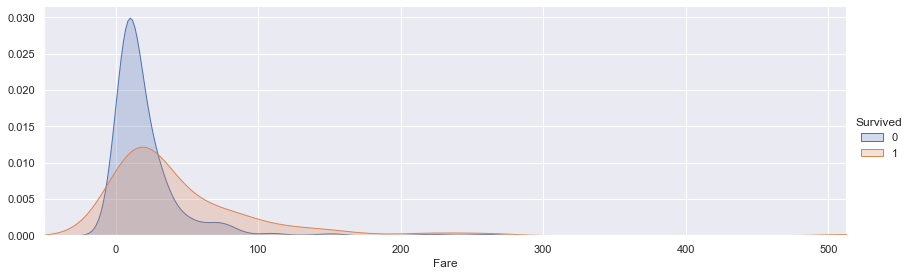

In [6]:
# Fare miss one value, filling out with the medium
df.Fare = df.Fare.fillna(df.Fare.median())

# review fare data distribution
fg = sns.FacetGrid(df_tr, hue="Survived",aspect=3, height=4)
fg.map(sns.kdeplot, 'Fare', shade=True)
fg.set(xlim=(-50, df.Fare.max()))
fg.add_legend()
plt.show()

In [7]:
# there is too many noisy for fare features. Do the re-distribution.
# Making bins
df['FareBin_4'] = pd.qcut(df.Fare, 4)
df['FareBin_5'] = pd.qcut(df.Fare, 5)
df['FareBin_6'] = pd.qcut(df.Fare, 6)

# Mapping the bins
label_encoder = LabelEncoder()
df['FareBin_4#'] = label_encoder.fit_transform(df['FareBin_4'])
df['FareBin_5#'] = label_encoder.fit_transform(df['FareBin_5'])
df['FareBin_6#'] = label_encoder.fit_transform(df['FareBin_6'])


In [8]:
# fill age missing value with KNN imputer
df['Age_pred'] = df.Age
selected_features = ['PassengerId','Pclass#', 'Sex#', 'SibSp', 'Parch', 'Fare', 'Age_pred']
# train the imputer
imputer = KNNImputer(n_neighbors=10, missing_values=np.nan)
imputer.fit(df[selected_features])

# fill value
df.loc[:, selected_features] = pd.DataFrame(imputer.transform(df[selected_features]), index=df.index, columns = selected_features)
df.loc[df.Age.isnull()].head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex#,Pclass#,Embarked#,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Embarked_3,FareBin_4,FareBin_5,FareBin_6,FareBin_4#,FareBin_5#,FareBin_6#,Age_pred
5,6.0,0.0,"Moran, Mr. James",NaN,0.0,0.0,330877,8.4583,NaN,1.0,3.0,3,0,1,0,0,1,0,0,1,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1,23.6
17,18.0,1.0,"Williams, Mr. Charles Eugene",NaN,0.0,0.0,244373,13.0000,NaN,1.0,2.0,1,0,1,0,1,0,1,0,0,"(7.896, 14.454]","(10.5, 21.558]","(8.662, 14.454]",1,2,2,21.0
19,20.0,1.0,"Masselmani, Mrs. Fatima",NaN,0.0,0.0,2649,7.2250,NaN,0.0,3.0,2,1,0,0,0,1,0,1,0,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,30.1
26,27.0,0.0,"Emir, Mr. Farred Chehab",NaN,0.0,0.0,2631,7.2250,NaN,1.0,3.0,2,0,1,0,0,1,0,1,0,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0,31.0
28,29.0,1.0,"O'Dwyer, Miss. Ellen ""Nellie""",NaN,0.0,0.0,330959,7.8792,NaN,0.0,3.0,3,1,0,0,0,1,0,0,1,"(-0.001, 7.896]","(7.854, 10.5]","(7.775, 8.662]",0,1,1,26.1


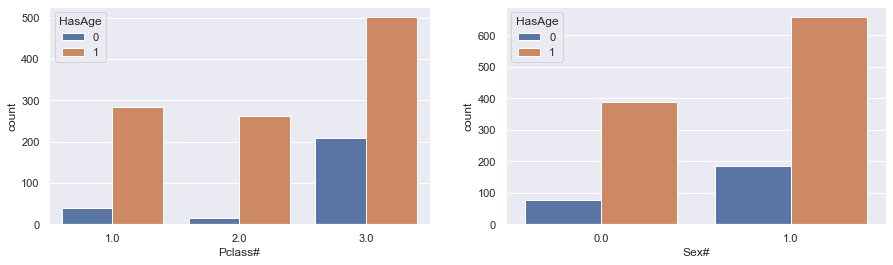

In [9]:
df['HasAge'] = df.Age.notnull().map({True: 1, False: 0})
fig, [ax1, ax2] = plt.subplots(1, 2)

fig.set_figwidth(15)
sns.countplot(x=df['Pclass#'], hue=df['HasAge'], ax=ax1)
sns.countplot(x=df['Sex#'], hue=df['HasAge'], ax=ax2)
plt.show()
# highest missing value in age when corresponding to PClass = 3
# The right graph shows higher age-missing rate for males than females

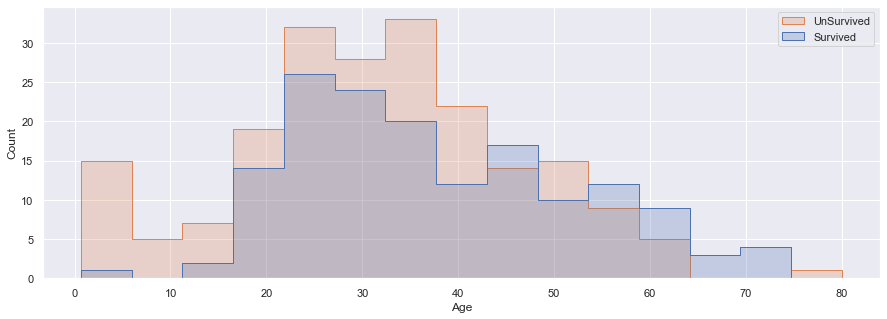

In [10]:
# see the age tendancy when pcalss !=3
df_age = df.loc[((df.HasAge == 1) & (df['Pclass#'] != 3 ))]
fg, ax = plt.subplots(figsize=(15, 5))
ax = sns.histplot(df_age, x='Age', hue='Survived', kde=False, bins=15, palette='deep', label='Survived', element='step')
ax.legend(['UnSurvived', 'Survived'])
plt.show()

In [11]:
# Low survival rate appears when Age < 16. When Age > 16, the distribution is not that distinct
df['Agesmall16'] = ((df.Age_pred) < 16)*1

In [12]:
# We can assume that passengers with same Ticket are friends or families.
duplicates = []

for uniq in df.Ticket.unique():
    temp = df.loc[df.Ticket == uniq, 'Name']
    if temp.count() > 1:
        duplicates.append(df.loc[df.Ticket == uniq, ['Name', 'Ticket', 'Fare', 'Survived']])
duplicates = pd.concat(duplicates)
duplicates.head(30)

,Name,Ticket,Fare,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,0.0


In [13]:
df['Relation_Survival'] = 0.5

for ticket_num, df_gp in df.groupby('Ticket'):
    if len(df_gp) > 1: # We just want the data with duplicated tickets
            for index, row in df_gp.iterrows():
                smax = df_gp.drop(index).Survived.max()
                smin = df_gp.drop(index).Survived.min()
                pid = row.PassengerId
                if smax == 1.0:
                    df.loc[df['PassengerId'] == pid, 'Relation_Survival'] = 1
                elif smin == 0.0:
                    df.loc[df['PassengerId'] == pid, 'Relation_Survival'] = 0

In [14]:
df.Relation_Survival

0       0.5
1       0.5
2       0.5
3       0.0
4       0.5
       ... 
1304    0.5
1305    1.0
1306    0.5
1307    0.5
1308    1.0
Name: Relation_Survival, Length: 1309, dtype: float64

In [15]:
df_train = df[:len(df_tr)]
df_test = df[len(df_tr):]

In [16]:
cor_matrix = df_train.corr()
cor_matrix

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex#,Pclass#,Embarked#,Sex_0,Sex_1,Pclass_1,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Embarked_3,FareBin_4#,FareBin_5#,FareBin_6#,Age_pred,HasAge,Agesmall16,Relation_Survival
PassengerId,1.000000,-0.005007,0.036847,-0.057527,-0.001652,0.012658,0.042939,-0.035144,-0.030444,-0.042939,0.042939,0.034303,-0.000086,-0.029486,0.022148,-0.001199,-0.033606,-0.024611,-0.006580,-0.017366,0.041418,0.020167,-0.023668,0.030376
Survived,-0.005007,1.000000,-0.077221,-0.035322,0.081629,0.257307,-0.543351,-0.338481,0.111203,0.543351,-0.543351,0.285904,0.093349,-0.322308,-0.155660,0.174718,0.003650,0.306855,0.317386,0.323695,-0.071131,0.092197,0.140244,0.343614
Age,0.036847,-0.077221,1.000000,-0.308247,-0.189119,0.096067,0.093254,-0.369226,0.017651,-0.093254,0.093254,0.348941,0.006954,-0.312271,-0.032523,0.046138,-0.022405,0.096250,0.131815,0.113827,1.000000,NaN,-0.582875,0.063622
SibSp,-0.057527,-0.035322,-0.308247,1.000000,0.414838,0.159651,-0.114631,0.083081,-0.061591,0.114631,-0.114631,-0.054582,-0.055932,0.092548,0.070941,-0.061970,-0.026354,0.378720,0.356492,0.360421,-0.218088,-0.018958,0.348727,-0.205054
Parch,-0.001652,0.081629,-0.189119,0.414838,1.000000,0.216225,-0.245489,0.018443,-0.080277,0.245489,-0.245489,-0.017633,-0.000734,0.015790,0.063036,-0.013725,-0.081228,0.374659,0.347618,0.367726,-0.171192,0.124104,0.347779,-0.020063
Fare,0.012658,0.257307,0.096067,0.159651,0.216225,1.000000,-0.182333,-0.549500,0.065492,0.182333,-0.182333,0.591711,-0.118557,-0.413333,-0.166603,0.273614,-0.117216,0.583181,0.602012,0.609014,0.102696,0.100707,0.003988,0.307091
Sex#,0.042939,-0.543351,0.093254,-0.114631,-0.245489,-0.182333,1.000000,0.131900,-0.121266,-1.000000,1.000000,-0.098013,-0.064746,0.137143,0.125722,-0.090223,-0.074115,-0.239812,-0.244137,-0.250093,0.076703,-0.055215,-0.107712,-0.056500
Pclass#,-0.035144,-0.338481,-0.369226,0.083081,0.018443,-0.549500,0.131900,1.000000,0.040138,-0.131900,0.131900,-0.885924,-0.188432,0.916673,0.081720,-0.251139,0.221009,-0.644180,-0.704620,-0.691711,-0.339861,-0.172933,0.115252,-0.303375
Embarked#,-0.030444,0.111203,0.017651,-0.061591,-0.080277,0.065492,-0.121266,0.040138,1.000000,0.121266,-0.121266,0.051301,-0.191476,0.111632,-0.923506,0.486004,0.791573,-0.089889,-0.086690,-0.080640,-0.004009,-0.316939,-0.015377,0.054817
Sex_0,-0.042939,0.543351,-0.093254,0.114631,0.245489,0.182333,-1.000000,-0.131900,0.121266,1.000000,-1.000000,0.098013,0.064746,-0.137143,-0.125722,0.090223,0.074115,0.239812,0.244137,0.250093,-0.076703,0.055215,0.107712,0.056500


In [17]:
corr_mat_fil = cor_matrix.loc[:, 'Survived'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])
corr_mat_fil

,Survived
Sex_0,0.543351
Relation_Survival,0.343614
FareBin_6#,0.323695
FareBin_5#,0.317386
FareBin_4#,0.306855
Pclass_1,0.285904
Fare,0.257307
Embarked_2,0.174718
Agesmall16,0.140244
Embarked#,0.111203


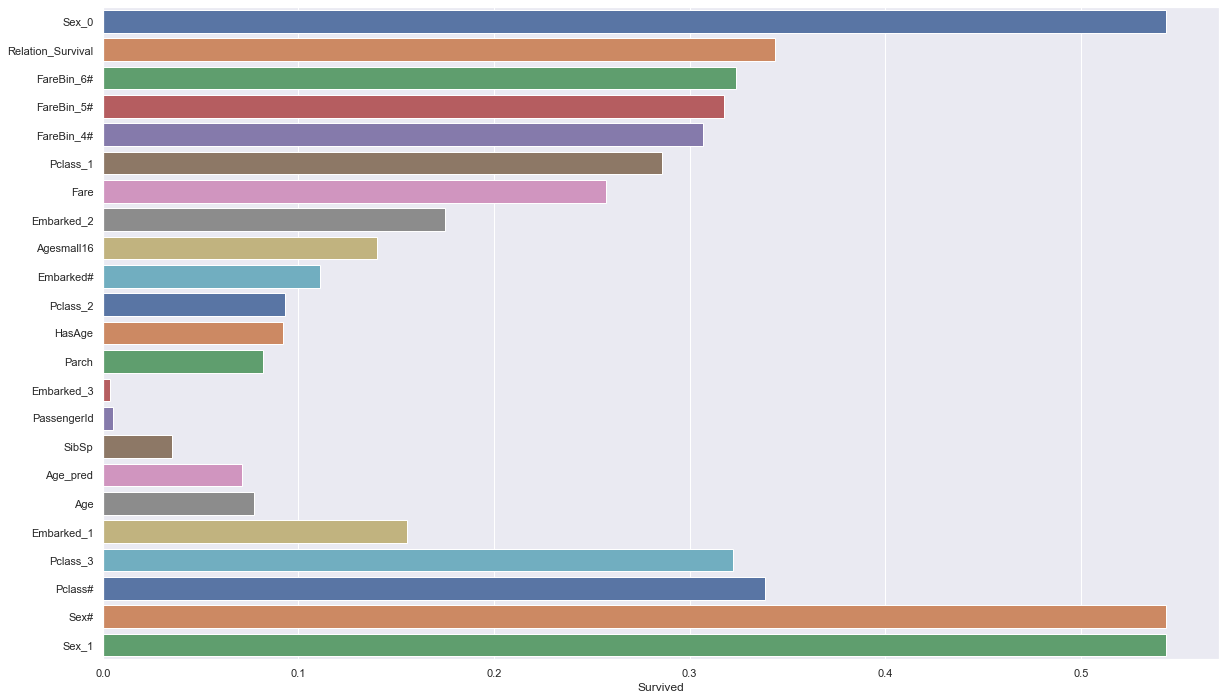

In [42]:
plt.figure(figsize=(20,12))
bar = sns.barplot(x=corr_mat_fil.Survived.abs(), y=corr_mat_fil.index, data=corr_mat_fil, palette='deep');

In [38]:
selected_features = ['Sex#', 'Pclass#', 'FareBin_5#', 'Relation_Survival', 'Agesmall16']
x_train = df_train[selected_features]
y_train = df_train['Survived']
x_test = df_test[selected_features]
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [21]:
model1 = RandomForestClassifier(random_state=5)

grid_parameters = {'n_estimators': [i for i in range(50, 601, 50)], 'min_samples_split' : [10, 20, 30, 40]}
grid = GridSearchCV(estimator=model1, param_grid=grid_parameters)
grid_result = grid.fit(x_train, y_train)

# summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8428410018203503 using {'min_samples_split': 40, 'n_estimators': 250}


In [39]:
RFC = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20)
RFC.fit(x_train, y_train)
y_pred = RFC.predict(x_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
output = output.astype('int')
output.to_csv('RFC_prediction_6.csv', index=False)

In [29]:
model2 = xgb.XGBClassifier(objective ='reg:squarederror')

grid_parameters = {'n_estimators': [i for i in range(50, 601, 50)], 'colsample_bytree' : [i for i in np.arange(0.1, 1.0, 0.1)],
                  'subsample': [i for i in np.arange(0.1, 1.0, 0.1)]}
grid = GridSearchCV(estimator=model2, param_grid=grid_parameters)
grid_result = grid.fit(x_train, y_train)

# summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.8395016006528152 using {'colsample_bytree': 0.6, 'n_estimators': 150, 'subsample': 0.6}


In [40]:
XGBC = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree=0.6, subsample=0.6, n_estimators=150)
XGBC.fit(x_train, y_train)
y_pred = XGBC.predict(x_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})
output = output.astype('int')
output.to_csv('XGB_prediction_2.csv', index=False)